In [38]:
#import libary
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [39]:
#read train data
train = pd.read_csv("train.csv")
#read test data
test = pd.read_csv("test.csv")
#read submission data
submission = pd.read_csv("sample_submission.csv")

# 2. Data Exploration

In [40]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [42]:
train.nunique()

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

In [43]:
train['Cabin']

0          B/0/P
1          F/0/S
2          A/0/S
3          A/0/S
4          F/1/S
          ...   
8688      A/98/P
8689    G/1499/S
8690    G/1500/S
8691     E/608/S
8692     E/608/S
Name: Cabin, Length: 8693, dtype: object

In [44]:
cat_cols = ["HomePlanet","CryoSleep","Cabin","Destination", "VIP"]
cont_cols = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

# 3. Data Preparation




In [45]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [46]:
simp_num = SimpleImputer(missing_values = np.nan, strategy = "mean")
simp_cat = SimpleImputer(missing_values = np.nan, strategy = "most_frequent")

In [47]:
for col in cat_cols:
    train[col] = simp_cat.fit_transform(train[col].values.reshape(-1,1))[:,0]
    test[col] = simp_cat.transform(test[col].values.reshape(-1,1))[:,0]

for col in cont_cols:
    train[col] = simp_num.fit_transform(train[col].values.reshape(-1,1))[:,0]
    test[col] = simp_num.transform(test[col].values.reshape(-1,1))[:,0]

In [48]:
# New features - training set
train['Deck'] = train['Cabin'].apply(lambda x: str(x).split('/')[0])
train['Number'] = train['Cabin'].apply(lambda x:  str(x).split('/')[1]).astype(int)
train['Side'] = train['Cabin'].apply(lambda x:  str(x).split('/')[2])

# New features - test set
test['Deck'] = test['Cabin'].apply(lambda x: str(x).split('/')[0])
test['Number'] = test['Cabin'].apply(lambda x: str(x).split('/')[1]).astype(int)
test['Side'] = test['Cabin'].apply(lambda x: str(x).split('/')[2])

In [49]:
cat_cols.append('Deck')
cat_cols.append('Side')
cont_cols.append('Number')

In [50]:
def encoder(df):
    
    for col in cat_cols:
        le = LabelEncoder()
        le.fit(df[col])
        df[col] = le.transform(df[col])
        
    for col in cont_cols:
        df[col] = np.log1p(df[col])
    
    return df

In [51]:
target = train['Transported'] 
let = LabelEncoder()
let.fit(target)
train = encoder(train)
test = encoder(test)

# 4. Modeling

## Feature Selections

In [53]:
y = let.transform(target)

#delete data train = PassegerId, Name, Transported
cols_to_drop = ['PassengerId', 'Cabin', 'Name','Transported']
#delete data test = PassegerId, Name, Transported
cols_to_drop_test = ['PassengerId', 'Cabin', 'Name']

train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop_test, axis=1)

X = train.values

In [54]:
train

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Number,Side
0,1,0,2,3.688879,0,0.000000,0.000000,0.000000,0.000000,0.000000,1,0.000000,0
1,0,0,2,3.218876,0,4.700480,2.302585,3.258097,6.309918,3.806662,5,0.000000,1
2,1,0,2,4.077537,1,3.784190,8.182280,0.000000,8.812248,3.912023,0,0.000000,1
3,1,0,2,3.526361,0,0.000000,7.157735,5.918894,8.110728,5.267858,0,0.000000,1
4,0,0,2,2.833213,0,5.717028,4.262680,5.023881,6.338594,1.098612,5,0.693147,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,1,0,0,3.737670,1,0.000000,8.827615,0.000000,7.404888,4.317488,0,4.595120,0
8689,0,1,1,2.944439,0,0.000000,0.000000,0.000000,0.000000,0.000000,6,7.313220,1
8690,0,0,2,3.295837,0,0.000000,0.000000,7.535297,0.693147,0.000000,6,7.313887,1
8691,1,0,0,3.496508,0,0.000000,6.956545,0.000000,5.869297,8.082093,4,6.411818,1


In [55]:
test

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Number,Side
0,0,1,2,3.332205,0,0.000000,0.000000,0.000000,0.000000,0.000000,6,1.386294,1
1,0,0,2,2.995732,0,0.000000,2.302585,0.000000,7.945910,0.000000,5,1.609438,1
2,1,1,0,3.465736,0,0.000000,0.000000,0.000000,0.000000,0.000000,2,0.000000,1
3,1,0,2,3.663562,0,0.000000,8.802823,0.000000,5.204007,6.373320,2,0.693147,1
4,0,0,2,3.044522,0,2.397895,0.000000,6.455199,0.000000,0.000000,5,1.791759,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,0,1,2,3.555348,0,0.000000,0.000000,0.000000,0.000000,0.000000,6,7.311218,1
4273,0,0,2,3.761200,0,0.000000,6.742881,2.890372,2.397895,4.976734,6,6.599870,1
4274,2,1,0,3.395445,0,0.000000,0.000000,0.000000,0.000000,0.000000,3,5.693732,0
4275,1,0,2,3.395445,0,0.000000,7.893945,0.000000,0.000000,6.261492,3,5.697093,0


## K-Nearest-Neighbors

In [56]:
grid_params = { 'n_neighbors' : range(45,100),
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']
               }
# n neighbours is the value of k

gs = GridSearchCV(KNeighborsClassifier(), grid_params, verbose = 1, cv = 3, n_jobs = -1)
# n_jobs is set to -1 which means that the job of finding a good fit will be handled by the Python interpreter on its own.

g_res = gs.fit(X, y)

Fitting 3 folds for each of 330 candidates, totalling 990 fits


In [57]:
# find the best score
g_res.best_score_

0.7929386269273109

In [58]:
g_res.best_params_

{'metric': 'manhattan', 'n_neighbors': 46, 'weights': 'distance'}

In [59]:
classifier = KNeighborsClassifier(n_neighbors = 19, weights = 'uniform',metric = 'manhattan')
classifier.fit(X, y)

y_pred = classifier.predict(test.values)

In [60]:
y_pred

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

In [61]:
y_pred = y_pred.astype(str)
# replace prediction value false = 0
y_pred = np.char.replace(y_pred, '0', 'False')
# replace prediction value false = 1
y_pred = np.char.replace(y_pred, '1', 'True')
# show 
y_pred

array(['True', 'False', 'True', ..., 'True', 'True', 'True'], dtype='<U5')

In [62]:
# submision = transport
submission['Transported'] = y_pred

submission.to_csv('submission.csv', index=False)
# turn to my result
my_submission = pd.read_csv("submission.csv")
#show
my_submission

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
y_pred = classifier.predict(X_test)

In [64]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1303
           1       0.82      0.81      0.82      1305

    accuracy                           0.82      2608
   macro avg       0.82      0.82      0.82      2608
weighted avg       0.82      0.82      0.82      2608



In [65]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
print(f"The model's accuracy score is {round(accuracy_score(y_test, y_pred)*100, 2)}%")

The model's accuracy score is 81.83%


In [66]:
print('Training set score: ', classifier.score(X_train, y_train))
print('Test set score: ', classifier.score(X_test, y_test))

Training set score:  0.8147904683648316
Test set score:  0.8182515337423313


In [67]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

[[1075  228]
 [ 246 1059]]


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

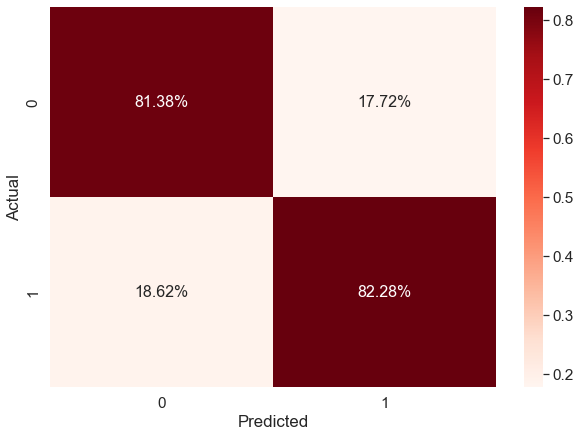

In [68]:
import matplotlib.pyplot as plt
import seaborn as  sns

data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_pred))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm/np.sum(df_cm), cmap="Reds", annot=True,annot_kws={"size": 16}, fmt = '.2%')

In [69]:
y_test

array([1, 1, 0, ..., 1, 1, 0], dtype=int64)

In [70]:
y_pred

array([0, 1, 0, ..., 1, 1, 0], dtype=int64)